In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import chi2
from scipy.linalg import inv, eig
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 自定义典型相关分析类（适配多变量组关联）
class CanonicalCorrelationAnalysis:
    def __init__(self, n_components=3):
        self.n_components = n_components  # 提取典型变量对数量
        self.X_weights = None  # X组权重（典型系数）
        self.Y_weights = None  # Y组权重（典型系数）
        self.X_scores = None  # X组典型变量得分
        self.Y_scores = None  # Y组典型变量得分
        self.corr_coeffs = None  # 典型相关系数
        self.p_values = None  # 显著性检验p值

    def fit(self, X, Y):
        """拟合CCA模型"""
        # 计算协方差矩阵
        n = X.shape[0]
        cov_xx = np.cov(X.T)
        cov_yy = np.cov(Y.T)
        cov_xy = np.cov(X.T, Y.T)[:X.shape[1], X.shape[1]:]
        cov_yx = cov_xy.T

        # 求解典型相关系数和权重（避免奇异矩阵）
        cov_xx_inv = inv(cov_xx + 1e-6 * np.eye(cov_xx.shape[0]))
        cov_yy_inv = inv(cov_yy + 1e-6 * np.eye(cov_yy.shape[0]))
        
        # 计算特征值和特征向量
        matrix_x = cov_xx_inv @ cov_xy @ cov_yy_inv @ cov_yx
        eig_vals_x, eig_vecs_x = eig(matrix_x)
        matrix_y = cov_yy_inv @ cov_yx @ cov_xx_inv @ cov_xy
        eig_vals_y, eig_vecs_y = eig(matrix_y)

        # 排序（按特征值降序）
        idx_x = np.argsort(eig_vals_x.real)[::-1]
        idx_y = np.argsort(eig_vals_y.real)[::-1]
        
        eig_vals_x = eig_vals_x[idx_x].real
        eig_vecs_x = eig_vecs_x[:, idx_x].real
        eig_vals_y = eig_vals_y[idx_y].real
        eig_vecs_y = eig_vecs_y[:, idx_y].real

        # 提取典型相关系数（特征值开平方）
        self.corr_coeffs = np.sqrt(eig_vals_x[:self.n_components])
        # 提取典型权重（标准化后）
        self.X_weights = eig_vecs_x[:, :self.n_components]
        self.Y_weights = eig_vecs_y[:, :self.n_components]

        # 计算典型变量得分
        self.X_scores = X @ self.X_weights
        self.Y_scores = Y @ self.Y_weights

        # 显著性检验（Wilks' Lambda）
        self._significance_test(X, Y, eig_vals_x)
        return self

    def _significance_test(self, X, Y, eig_vals):
        """Wilks' Lambda显著性检验"""
        n = X.shape[0]
        p = X.shape[1]
        q = Y.shape[1]
        self.p_values = []

        for k in range(self.n_components):
            # 计算Wilks' Lambda
            lambda_k = np.prod(1 - eig_vals[k:min(p, q)])
            # 卡方统计量
            chi2_stat = -(n - 1 - (p + q + 1) / 2) * np.log(lambda_k)
            # 自由度
            df = (p - k) * (q - k)
            # p值（卡方分布）
            p_val = 1 - chi2.cdf(chi2_stat, df)
            self.p_values.append(p_val)

    def redundancy_analysis(self, X, Y):
        """冗余分析（Redundancy Analysis）"""
        # X组被Y组解释的冗余度
        redundancy_x = np.mean([np.corrcoef(X[:, i], self.Y_scores[:, 0])[0, 1]**2 
                               for i in range(X.shape[1])])
        # Y组被X组解释的冗余度
        redundancy_y = np.mean([np.corrcoef(Y[:, i], self.X_scores[:, 0])[0, 1]**2 
                               for i in range(Y.shape[1])])
        return redundancy_x, redundancy_y

In [18]:
# 加载数据（与第七章保持一致）
df = pd.read_csv('main_data_advanced.csv')

# 选择2019-2023年完整数据（面板数据，按城市-年份堆叠）
df_panel = df.copy()

# 定义两组变量
## X组：数据流动指标组（12个核心指标）
X_cols = [
    '跨境数据传输总量_TB', '入境数据量_TB', '出境数据量_TB',
    '数据中心数量', '互联网国际出口带宽_Gbps', 'IaaS使用量_万核时',
    'PaaS使用量_万次调用', 'SaaS活跃用户数_万', '数据交易额_亿元',
    '数据交易笔数_万笔', 'API调用总量_亿次', '区块链存证量_万条'
]
# 计算API调用总量（政务+金融+医疗+电商）
df_panel['API调用总量_亿次'] = df_panel[['政务API调用量_亿次', '金融API调用量_亿次', 
                                   '医疗API调用量_亿次', '电商API调用量_亿次']].sum(axis=1)

## Y组：经济创新指标组（10个核心指标）
Y_cols = [
    'GDP_亿元', '数字经济核心产业增加值_亿元', '人均GDP_万元',
    '研发经费投入_亿元', '发明专利授权量', '高新技术企业数',
    '外贸进出口总额_亿元', '跨境电商交易额_亿元',
    '金融科技交易规模_亿元', '技术合同成交额_亿元'
]

# 数据预处理（删除含缺失值的行，标准化）
df_analysis = df_panel[X_cols + Y_cols].dropna()
X_raw = df_analysis[X_cols].values
Y_raw = df_analysis[Y_cols].values

# 标准化（消除量纲影响）
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X = scaler_X.fit_transform(X_raw)
Y = scaler_Y.fit_transform(Y_raw)

# 查看数据基本信息
print(f"样本量：{X.shape[0]}（城市-年份观测值）")
print(f"X组变量数：{X.shape[1]}（数据流动指标）")
print(f"Y组变量数：{Y.shape[1]}（经济创新指标）")
print(f"\nX组变量：{X_cols}")
print(f"Y组变量：{Y_cols}")

样本量：55（城市-年份观测值）
X组变量数：12（数据流动指标）
Y组变量数：10（经济创新指标）

X组变量：['跨境数据传输总量_TB', '入境数据量_TB', '出境数据量_TB', '数据中心数量', '互联网国际出口带宽_Gbps', 'IaaS使用量_万核时', 'PaaS使用量_万次调用', 'SaaS活跃用户数_万', '数据交易额_亿元', '数据交易笔数_万笔', 'API调用总量_亿次', '区块链存证量_万条']
Y组变量：['GDP_亿元', '数字经济核心产业增加值_亿元', '人均GDP_万元', '研发经费投入_亿元', '发明专利授权量', '高新技术企业数', '外贸进出口总额_亿元', '跨境电商交易额_亿元', '金融科技交易规模_亿元', '技术合同成交额_亿元']


In [26]:
# 拟合CCA模型（提取3对典型变量）
cca = CanonicalCorrelationAnalysis(n_components=3)
cca.fit(X, Y)

# 输出X组（数据流动）典型权重
print("="*50)
print("6.1.1 典型变量提取")
print("="*50)
print("\nX组（数据流动）典型权重（第1-3对典型变量）：")
X_weights_df = pd.DataFrame(
    cca.X_weights,
    index=X_cols,
    columns=[f'典型变量{i+1}' for i in range(cca.n_components)]
)
print(X_weights_df.round(3))

# 输出Y组（经济创新）典型权重
print("\nY组（经济创新）典型权重（第1-3对典型变量）：")
Y_weights_df = pd.DataFrame(
    cca.Y_weights,
    index=Y_cols,
    columns=[f'典型变量{i+1}' for i in range(cca.n_components)]
)
print(Y_weights_df.round(3))

# 提取典型变量表达式（示例：第1对）
print("\n第1对典型变量表达式：")
x_expr = "X1 = " + " + ".join([f"{cca.X_weights[i,0]:.3f}×{X_cols[i]}" for i in range(len(X_cols))])
y_expr = "Y1 = " + " + ".join([f"{cca.Y_weights[i,0]:.3f}×{Y_cols[i]}" for i in range(len(Y_cols))])
print(x_expr)
print(y_expr)

6.1.1 典型变量提取

X组（数据流动）典型权重（第1-3对典型变量）：
                典型变量1  典型变量2  典型变量3
跨境数据传输总量_TB     0.091 -0.060  0.014
入境数据量_TB        0.682 -0.567  0.586
出境数据量_TB       -0.518  0.462 -0.576
数据中心数量         -0.057 -0.162 -0.256
互联网国际出口带宽_Gbps  0.227  0.005  0.097
IaaS使用量_万核时     0.195 -0.039  0.192
PaaS使用量_万次调用    0.354  0.094  0.014
SaaS活跃用户数_万     0.003  0.039 -0.216
数据交易额_亿元        0.143  0.471  0.057
数据交易笔数_万笔       0.042 -0.423 -0.326
API调用总量_亿次      0.066 -0.001  0.126
区块链存证量_万条       0.115  0.149  0.202

Y组（经济创新）典型权重（第1-3对典型变量）：
                典型变量1  典型变量2  典型变量3
GDP_亿元          0.336  0.305  0.348
数字经济核心产业增加值_亿元 -0.717 -0.818 -0.614
人均GDP_万元        0.008 -0.033 -0.048
研发经费投入_亿元       0.521  0.144 -0.417
发明专利授权量        -0.022 -0.025  0.280
高新技术企业数        -0.055  0.155 -0.102
外贸进出口总额_亿元     -0.296  0.398  0.461
跨境电商交易额_亿元     -0.067  0.104 -0.049
金融科技交易规模_亿元    -0.021 -0.007  0.082
技术合同成交额_亿元     -0.079 -0.149  0.125

第1对典型变量表达式：
X1 = 0.091×跨境数据传输总量_TB + 0.682×入境数据量_TB + -0.518×出境数据量_TB 

6.1.2 相关性检验

一、典型相关系数：
第1对典型变量相关系数：0.970
第2对典型变量相关系数：0.711
第3对典型变量相关系数：0.658

二、Wilks' Lambda显著性检验（α=0.05）：
  典型变量对  Wilks' Lambda p值  显著性
0   第1对             0.000   显著
1   第2对             0.430  不显著
2   第3对             0.756  不显著

三、冗余分析结果：
X组（数据流动）被Y组（经济创新）解释的冗余度：0.398
Y组（经济创新）被X组（数据流动）解释的冗余度：0.420

解释：冗余度反映一组变量的总变异能被另一组变量的典型变量解释的比例，取值范围[0,1]，越接近1解释力越强。


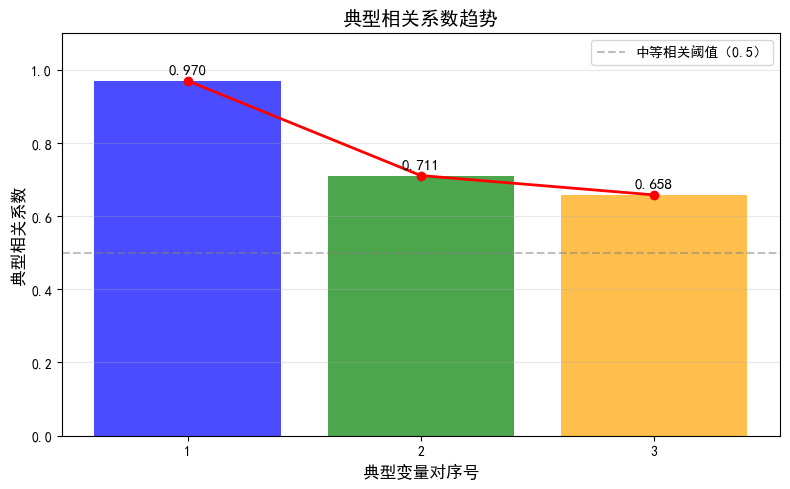

In [27]:
print("="*50)
print("6.1.2 相关性检验")
print("="*50)

# 1. 典型相关系数
print("\n一、典型相关系数：")
for i in range(cca.n_components):
    print(f"第{i+1}对典型变量相关系数：{cca.corr_coeffs[i]:.3f}")

# 2. Wilks' Lambda显著性检验（修正：转义单引号，避免语法冲突）
print("\n二、Wilks' Lambda显著性检验（α=0.05）：")
test_results = []
for i in range(cca.n_components):
    test_results.append({
        '典型变量对': f'第{i+1}对',
        'Wilks\' Lambda p值': round(cca.p_values[i], 3),  # 关键修正：Wilks\' 转义单引号
        '显著性': '显著' if cca.p_values[i] < 0.05 else '不显著'
    })
test_df = pd.DataFrame(test_results)
print(test_df)

# 3. 冗余分析
redundancy_x, redundancy_y = cca.redundancy_analysis(X, Y)
print("\n三、冗余分析结果：")
print(f"X组（数据流动）被Y组（经济创新）解释的冗余度：{redundancy_x:.3f}")
print(f"Y组（经济创新）被X组（数据流动）解释的冗余度：{redundancy_y:.3f}")
print("\n解释：冗余度反映一组变量的总变异能被另一组变量的典型变量解释的比例，取值范围[0,1]，越接近1解释力越强。")

# 4. 典型相关系数趋势图
plt.figure(figsize=(8, 5))
plt.bar(range(1, cca.n_components+1), cca.corr_coeffs, color=['blue', 'green', 'orange'], alpha=0.7)
plt.plot(range(1, cca.n_components+1), cca.corr_coeffs, 'o-', color='red', linewidth=2)
for i, coeff in enumerate(cca.corr_coeffs):
    plt.text(i+1, coeff+0.02, f'{coeff:.3f}', ha='center', fontsize=11)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='中等相关阈值（0.5）')
plt.title('典型相关系数趋势', fontsize=14)
plt.xlabel('典型变量对序号', fontsize=12)
plt.ylabel('典型相关系数', fontsize=12)
plt.xticks(range(1, cca.n_components+1))
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('典型相关系数趋势图.png', dpi=300, bbox_inches='tight')
plt.show()

6.1.3 结构系数解释

一、X组（数据流动）结构系数（变量-自身典型变量相关）：
                典型变量1  典型变量2  典型变量3
跨境数据传输总量_TB     0.636 -0.513  0.023
入境数据量_TB        0.639 -0.534  0.033
出境数据量_TB        0.630 -0.488  0.014
数据中心数量          0.621 -0.367 -0.125
互联网国际出口带宽_Gbps  0.796 -0.097  0.008
IaaS使用量_万核时     0.623 -0.263  0.319
PaaS使用量_万次调用    0.780  0.358 -0.104
SaaS活跃用户数_万     0.580 -0.024 -0.429
数据交易额_亿元        0.604  0.288 -0.574
数据交易笔数_万笔       0.575  0.244 -0.588
API调用总量_亿次      0.661  0.019  0.205
区块链存证量_万条       0.623  0.277  0.367

二、Y组（经济创新）结构系数（变量-自身典型变量相关）：
                典型变量1  典型变量2  典型变量3
GDP_亿元         -0.810  0.190 -0.142
数字经济核心产业增加值_亿元 -0.857  0.072 -0.166
人均GDP_万元       -0.102 -0.238 -0.276
研发经费投入_亿元      -0.763  0.145 -0.169
发明专利授权量        -0.619 -0.054  0.397
高新技术企业数        -0.533  0.453 -0.091
外贸进出口总额_亿元     -0.790  0.284 -0.108
跨境电商交易额_亿元     -0.726  0.031  0.018
金融科技交易规模_亿元    -0.365 -0.045  0.068
技术合同成交额_亿元     -0.723 -0.299  0.078

三、强相关变量汇总（结构系数|r|>0.5，核心解释变量）：

第1对典型变量：
X组核心变量：['跨境数据传输总量_TB'

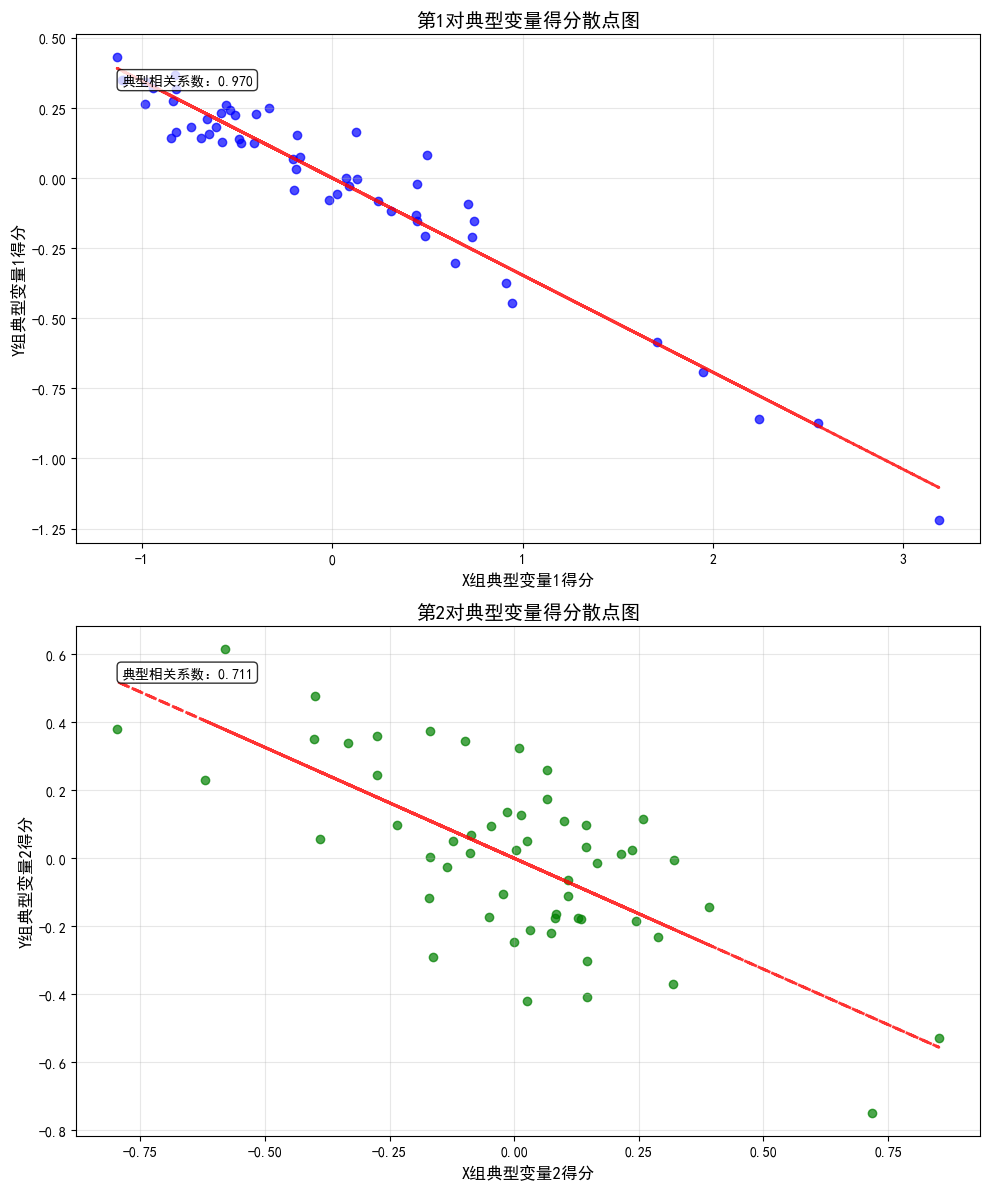

In [28]:
print("="*50)
print("6.1.3 结构系数解释")
print("="*50)

# 定义结构系数计算函数
def calculate_structural_coeffs(data, scores):
    """计算结构系数（变量与自身典型变量的相关系数）"""
    n_vars = data.shape[1]
    n_components = scores.shape[1]
    struct_coeffs = np.zeros((n_vars, n_components))
    for i in range(n_vars):
        for j in range(n_components):
            struct_coeffs[i, j] = np.corrcoef(data[:, i], scores[:, j])[0, 1]
    return struct_coeffs

# 计算X组和Y组的结构系数
X_struct_coeffs = calculate_structural_coeffs(X, cca.X_scores)
Y_struct_coeffs = calculate_structural_coeffs(Y, cca.Y_scores)

# 输出X组结构系数
print("\n一、X组（数据流动）结构系数（变量-自身典型变量相关）：")
X_struct_df = pd.DataFrame(
    X_struct_coeffs,
    index=X_cols,
    columns=[f'典型变量{i+1}' for i in range(cca.n_components)]
)
print(X_struct_df.round(3))

# 输出Y组结构系数
print("\n二、Y组（经济创新）结构系数（变量-自身典型变量相关）：")
Y_struct_df = pd.DataFrame(
    Y_struct_coeffs,
    index=Y_cols,
    columns=[f'典型变量{i+1}' for i in range(cca.n_components)]
)
print(Y_struct_df.round(3))

# 提取强相关变量（结构系数绝对值>0.5）
print("\n三、强相关变量汇总（结构系数|r|>0.5，核心解释变量）：")
for i in range(cca.n_components):
    print(f"\n第{i+1}对典型变量：")
    x_strong = X_struct_df[X_struct_df[f'典型变量{i+1}'].abs() > 0.5].index.tolist()
    y_strong = Y_struct_df[Y_struct_df[f'典型变量{i+1}'].abs() > 0.5].index.tolist()
    print(f"X组核心变量：{x_strong}")
    print(f"Y组核心变量：{y_strong}")
    print(f"关联含义：反映{', '.join(x_strong)}与{', '.join(y_strong)}的强线性关联")

# 典型变量得分散点图（上下布局：2行1列）
print("\n四、典型变量得分散点图（直观展示关联强度）：")
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# 第1对典型变量（上半部分）
axes[0].scatter(cca.X_scores[:, 0], cca.Y_scores[:, 0], alpha=0.7, color='blue')
z = np.polyfit(cca.X_scores[:, 0], cca.Y_scores[:, 0], 1)
p = np.poly1d(z)
axes[0].plot(cca.X_scores[:, 0], p(cca.X_scores[:, 0]), "r--", alpha=0.8, linewidth=2)
axes[0].annotate(f'典型相关系数：{cca.corr_coeffs[0]:.3f}', 
                 xy=(0.05, 0.9), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
axes[0].set_title('第1对典型变量得分散点图', fontsize=14)
axes[0].set_xlabel('X组典型变量1得分', fontsize=12)
axes[0].set_ylabel('Y组典型变量1得分', fontsize=12)
axes[0].grid(True, alpha=0.3)

# 第2对典型变量（下半部分）
axes[1].scatter(cca.X_scores[:, 1], cca.Y_scores[:, 1], alpha=0.7, color='green')
z = np.polyfit(cca.X_scores[:, 1], cca.Y_scores[:, 1], 1)
p = np.poly1d(z)
axes[1].plot(cca.X_scores[:, 1], p(cca.X_scores[:, 1]), "r--", alpha=0.8, linewidth=2)
axes[1].annotate(f'典型相关系数：{cca.corr_coeffs[1]:.3f}', 
                 xy=(0.05, 0.9), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
axes[1].set_title('第2对典型变量得分散点图', fontsize=14)
axes[1].set_xlabel('X组典型变量2得分', fontsize=12)
axes[1].set_ylabel('Y组典型变量2得分', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('典型变量得分散点图.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
print("="*50)
print("6.2.1 模型估计结果")
print("="*50)

# 定义因变量（Y组核心指标：数字经济核心产业增加值）
y = df_analysis['数字经济核心产业增加值_亿元'].values.reshape(-1, 1)
# 自变量：X组所有数据流动指标（标准化后）
X_pls = X

# 步骤1：确定最优成分数（10折交叉验证）
max_components = 8
cv_scores = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for n_comp in range(1, max_components+1):
    pls = PLSRegression(n_components=n_comp, scale=False)  # 已提前标准化
    r2_scores = cross_val_score(pls, X_pls, y, cv=kf, scoring='r2')
    cv_scores.append(np.mean(r2_scores))

# 找到最优成分数
best_n_comp = np.argmax(cv_scores) + 1
print("一、最优成分数确定（10折交叉验证）：")
cv_df = pd.DataFrame({
    '成分数': range(1, max_components+1),
    '交叉验证R²': [round(score, 3) for score in cv_scores]
})
print(cv_df)
print(f"\n最优成分数：{best_n_comp}（交叉验证R²最大）")

# 步骤2：拟合最优PLSR模型
pls_best = PLSRegression(n_components=best_n_comp, scale=False)
pls_best.fit(X_pls, y)

# 步骤3：模型性能评估
y_pred = pls_best.predict(X_pls)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

# 计算解释方差比例（修正版）
x_variance = np.var(X_pls, axis=0).sum()
x_scores_variance = np.var(pls_best.x_scores_, axis=0).sum()
x_explained_ratio = x_scores_variance / x_variance
y_explained_ratio = r2  # y的解释方差比例即R²

print("\n二、最优PLSR模型性能指标：")
print(f"R²（决定系数）：{r2:.3f}（模型解释因变量变异的比例）")
print(f"RMSE（均方根误差）：{rmse:.3f}（预测误差大小）")
print(f"解释方差比例：{x_explained_ratio:.1%}（X组）, {y_explained_ratio:.1%}（y）")

# 步骤4：输出回归系数
print("\n三、PLSR回归系数（数据流动变量对数字经济增加值的影响）：")
coef_df = pd.DataFrame({
    '变量名': X_cols,
    '回归系数': pls_best.coef_.flatten()
}).sort_values('回归系数', ascending=False)
print(coef_df.round(3))

6.2.1 模型估计结果
一、最优成分数确定（10折交叉验证）：
   成分数  交叉验证R²
0    1  -0.780
1    2  -1.424
2    3  -1.855
3    4  -2.422
4    5  -3.304
5    6  -4.049
6    7  -4.630
7    8  -4.679

最优成分数：1（交叉验证R²最大）

二、最优PLSR模型性能指标：
R²（决定系数）：0.691（模型解释因变量变异的比例）
RMSE（均方根误差）：4019.381（预测误差大小）
解释方差比例：46.1%（X组）, 69.1%（y）

三、PLSR回归系数（数据流动变量对数字经济增加值的影响）：
               变量名     回归系数
4   互联网国际出口带宽_Gbps  912.134
10      API调用总量_亿次  910.225
1         入境数据量_TB  781.737
0      跨境数据传输总量_TB  776.153
2         出境数据量_TB  765.463
11       区块链存证量_万条  747.435
6     PaaS使用量_万次调用  727.960
3           数据中心数量  704.301
5      IaaS使用量_万核时  667.578
7      SaaS活跃用户数_万  612.582
8         数据交易额_亿元  591.516
9        数据交易笔数_万笔  542.448


8.2.2 VIP重要性排序
一、VIP值排序（VIP>1为重要变量）：
               变量名   VIP值
4   互联网国际出口带宽_Gbps  1.238
10      API调用总量_亿次  1.236
1         入境数据量_TB  1.061
0      跨境数据传输总量_TB  1.054
2         出境数据量_TB  1.039
11       区块链存证量_万条  1.015
6     PaaS使用量_万次调用  0.988
3           数据中心数量  0.956
5      IaaS使用量_万核时  0.906
7      SaaS活跃用户数_万  0.832
8         数据交易额_亿元  0.803
9        数据交易笔数_万笔  0.736

重要变量（VIP>1）：['互联网国际出口带宽_Gbps', 'API调用总量_亿次', '入境数据量_TB', '跨境数据传输总量_TB', '出境数据量_TB', '区块链存证量_万条']（共6个）
核心变量（VIP>1.5）：[]（共0个）

解释：VIP值越大，变量对因变量（数字经济增加值）的预测贡献越大。


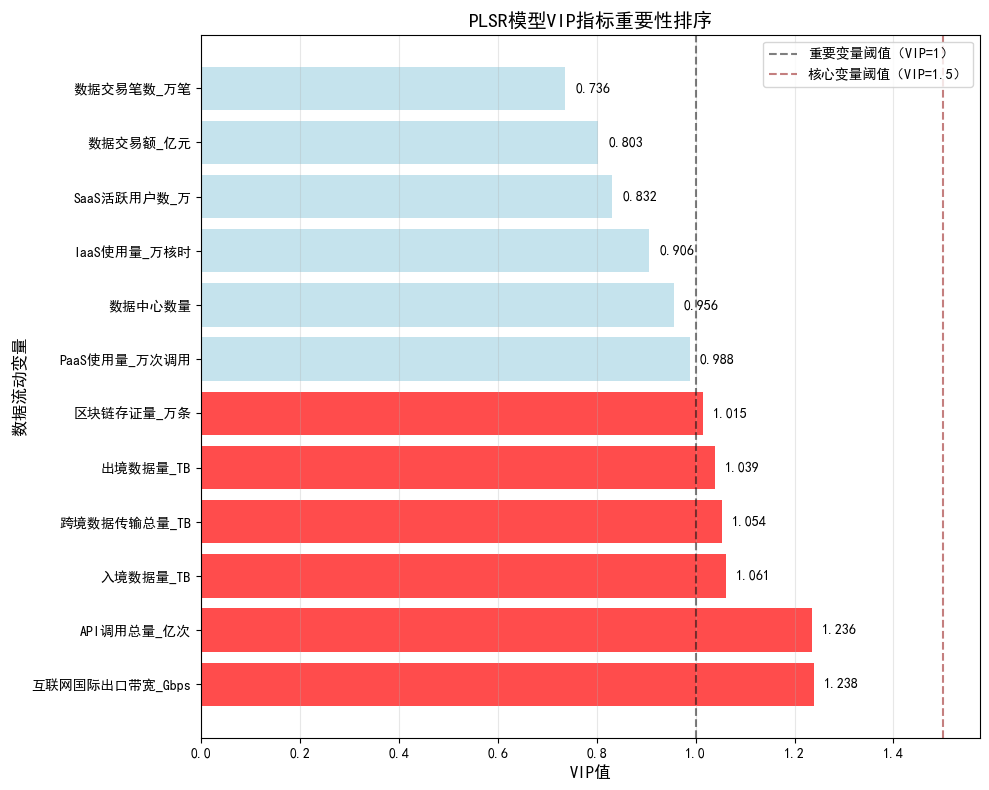

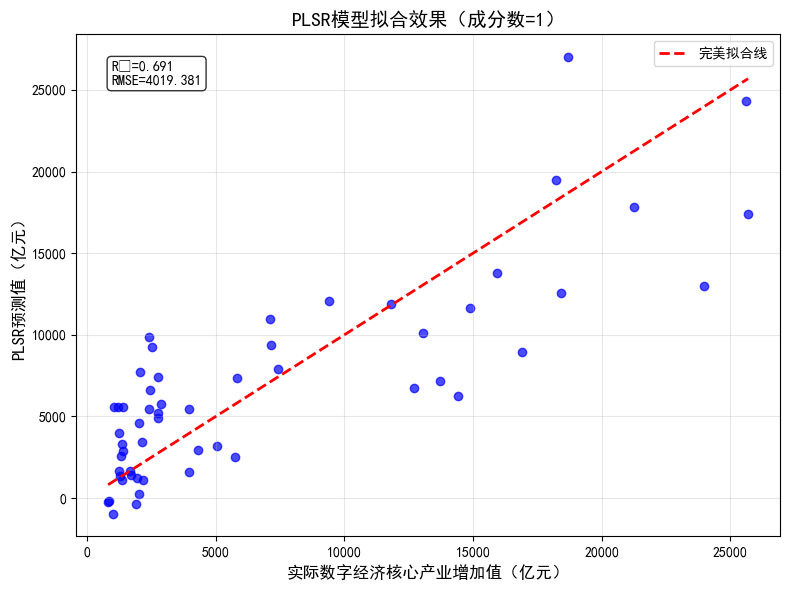

In [25]:
print("="*50)
print("8.2.2 VIP重要性排序")
print("="*50)

# 定义VIP计算函数（优化版，避免除零）
def calculate_vip(pls_model, X):
    """计算PLS回归的VIP值（Variable Importance in Projection）"""
    t = pls_model.x_scores_
    w = pls_model.x_weights_
    q = pls_model.y_loadings_
    p, h = w.shape
    vip = np.zeros(p)
    
    for j in range(p):
        sum_sq = 0
        for a in range(h):
            wja = w[j, a]
            ta_var = np.var(t[:, a])
            qa_var = np.sum(q[:, a]**2)
            sum_sq += wja**2 * ta_var * qa_var
        total_sq = np.sum(np.var(t, axis=0) * np.sum(q**2, axis=0))
        vip[j] = np.sqrt(p * sum_sq / (total_sq + 1e-8))  # 加微小值避免除零
    return vip

# 计算VIP值
vip_scores = calculate_vip(pls_best, X_pls)
vip_df = pd.DataFrame({
    '变量名': X_cols,
    'VIP值': vip_scores
}).sort_values('VIP值', ascending=False)

# 筛选重要变量（VIP>1为重要变量，VIP>1.5为核心变量）
important_vars = vip_df[vip_df['VIP值'] > 1]['变量名'].tolist()
core_vars = vip_df[vip_df['VIP值'] > 1.5]['变量名'].tolist()

print("一、VIP值排序（VIP>1为重要变量）：")
print(vip_df.round(3))
print(f"\n重要变量（VIP>1）：{important_vars}（共{len(important_vars)}个）")
print(f"核心变量（VIP>1.5）：{core_vars}（共{len(core_vars)}个）")
print("\n解释：VIP值越大，变量对因变量（数字经济增加值）的预测贡献越大。")

# 可视化VIP重要性（上下布局，单图）
plt.figure(figsize=(10, 8))
colors = ['darkred' if vip > 1.5 else 'red' if vip > 1 else 'lightblue' for vip in vip_df['VIP值']]
bars = plt.barh(vip_df['变量名'], vip_df['VIP值'], color=colors, alpha=0.7)
plt.axvline(x=1, color='black', linestyle='--', alpha=0.5, label='重要变量阈值（VIP=1）')
plt.axvline(x=1.5, color='darkred', linestyle='--', alpha=0.5, label='核心变量阈值（VIP=1.5）')
plt.xlabel('VIP值', fontsize=12)
plt.ylabel('数据流动变量', fontsize=12)
plt.title('PLSR模型VIP指标重要性排序', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3, axis='x')
# 添加数值标签
for i, (_, row) in enumerate(vip_df.iterrows()):
    plt.text(row['VIP值'] + 0.02, i, f'{row["VIP值"]:.3f}', va='center')
plt.tight_layout()
plt.savefig('PLSR_VIP重要性.png', dpi=300, bbox_inches='tight')
plt.show()

# 可视化模型拟合效果
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.7, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2, label='完美拟合线')
plt.xlabel('实际数字经济核心产业增加值（亿元）', fontsize=12)
plt.ylabel('PLSR预测值（亿元）', fontsize=12)
plt.title(f'PLSR模型拟合效果（成分数={best_n_comp}）', fontsize=14)
plt.annotate(f'R²={r2:.3f}\nRMSE={rmse:.3f}', 
             xy=(0.05, 0.9), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('PLSR拟合效果图.png', dpi=300, bbox_inches='tight')
plt.show()

# 保存关键结果到Excel（便于报告撰写）
with pd.ExcelWriter('典型相关与PLSR分析结果.xlsx', engine='openpyxl') as writer:
    # CCA结果
    X_weights_df.to_excel(writer, sheet_name='CCA_X权重')
    Y_weights_df.to_excel(writer, sheet_name='CCA_Y权重')
    X_struct_df.to_excel(writer, sheet_name='CCA_X结构系数')
    Y_struct_df.to_excel(writer, sheet_name='CCA_Y结构系数')
    # PLSR结果
    vip_df.to_excel(writer, sheet_name='PLSR_VIP排序', index=False)
    coef_df.to_excel(writer, sheet_name='PLSR回归系数', index=False)

